In [70]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [86]:
# Load data for training 
dec_data = np.loadtxt('published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
#split for Cross-Validation
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

# Load data for testing 
dec_test1 = np.loadtxt('published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

W = 40  # number of features from the 144 features
dim = 40  # number of LOB states(Limit Order Book-per tick)
horizon = 2 #For predicting for the 2nd next tick
T = 5 #For look back(data input for the prediction)

#taking the label(mid prices)
y_train = dec_train[-horizon, :].flatten()
y_val = dec_val[-horizon, :].flatten()
y_test = dec_test[-horizon, :].flatten()

#Removing the time for which no prediction will be made & converting to pytorch standard(0,1,2)
y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1

#Formatting for pytorch
dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print("Train shape:", dec_train.shape)
print("Val shape:", dec_val.shape)
print("Test shape:", dec_test.shape)


Train shape: (203800, 40)
Val shape: (50950, 40)
Test shape: (139587, 40)


In [87]:
class Dataset(data.Dataset):
    
    def __init__(self, x, y, num_classes, dim):
        self.num_classes = num_classes
        self.dim = dim
        self.x = x
        self.y = y
        self.length = x.shape[0] - T - self.dim + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        return input, self.y[i]


In [88]:
# Hyperparameters
batch_size = 32
epochs = 15
c_final = 2
n_heads = 2
c_in_axial = 8
c_out_axial = 8
pool_kernel = (1, 4)
pool_stride = (1, 4)
num_classes = 3

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)


In [114]:
def _conv1d1x1(in_channels, out_channels):
    return nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                         nn.BatchNorm1d(out_channels))
#class taken from https://github.com/jeya-maria-jose/Medical-Transformer/blob/main/lib/models/axialnet.py
class GatedAxialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dim, flag):
        assert (in_channels % heads == 0) and (out_channels % heads == 0)
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dim_head_v = out_channels // heads
        self.flag = flag
        self.dim = dim
        self.dim_head_qk = self.dim_head_v // 2
        self.qkv_channels = self.dim_head_v + self.dim_head_qk * 2
        self.to_qkv = _conv1d1x1(in_channels, self.heads * self.qkv_channels)
        self.bn_qkv = nn.BatchNorm1d(self.heads * self.qkv_channels)
        self.bn_similarity = nn.BatchNorm2d(heads * 3)
        self.bn_output = nn.BatchNorm1d(self.heads * self.qkv_channels)
        self.f_qr = nn.Parameter(torch.tensor(0.3), requires_grad=False)
        self.f_kr = nn.Parameter(torch.tensor(0.3), requires_grad=False)
        self.f_sve = nn.Parameter(torch.tensor(0.3), requires_grad=False)
        self.f_sv = nn.Parameter(torch.tensor(0.5), requires_grad=False)
        self.relative = nn.Parameter(torch.randn(self.dim_head_v * 2, dim * 2 - 1), requires_grad=True)
        query_index = torch.arange(dim).unsqueeze(0)
        key_index = torch.arange(dim).unsqueeze(1)
        relative_index = key_index - query_index + dim - 1
        self.register_buffer('flatten_index', relative_index.view(-1))
        self.reset_parameters()

    def forward(self, x):
        if self.flag:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)
        x = self.to_qkv(x)
        qkv = self.bn_qkv(x)
        q, k, v = torch.split(qkv.reshape(N * W, self.heads, self.dim_head_v * 2, H), [self.dim_head_v // 2, self.dim_head_v // 2, self.dim_head_v], dim=2)
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.dim_head_v * 2, self.dim, self.dim)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.dim_head_qk, self.dim_head_qk, self.dim_head_v], dim=0)
        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
        qk = torch.einsum('bgci, bgcj->bgij', q, k)
        qr = torch.mul(qr, self.f_qr)
        kr = torch.mul(kr, self.f_kr)
        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.heads, H, H).sum(dim=1)
        similarity = torch.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)
        sv = torch.mul(sv, self.f_sv)
        sve = torch.mul(sve, self.f_sve)
        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_channels * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_channels, 2, H).sum(dim=-2)
        if self.flag:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)
        return output

    def reset_parameters(self):
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.dim_head_v))

class AxialLOB(nn.Module):
    def __init__(self, W, H, c_in, c_out, c_final, n_heads, pool_kernel, pool_stride):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.c_final = c_final
        self.CNN_in = nn.Conv2d(in_channels=1, out_channels=c_in, kernel_size=1)
        self.CNN_out = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res2 = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res1 = nn.Conv2d(in_channels=1, out_channels=c_out, kernel_size=1)
        self.norm = nn.BatchNorm2d(c_in)
        self.res_norm2 = nn.BatchNorm2d(c_final)
        self.res_norm1 = nn.BatchNorm2d(c_out)
        self.norm2 = nn.BatchNorm2d(c_final)
        self.axial_height_1 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_1 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)
        self.axial_height_2 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_2 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)
        self.activation = nn.ReLU()
        self.linear = nn.Linear(800, 3)
        self.pooling = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)

    def forward(self, x):
        #Convolution layer
        y = self.CNN_in(x)
        y = self.norm(y)
        y = self.activation(y)
        #mutli head attention layer
        y = self.axial_width_1(y)
        y = self.axial_height_1(y)
        #Convolution layer
        x = self.CNN_res1(x)
        x = self.res_norm1(x)
        x = self.activation(x)
        #residual
        y = y + x
        z = y.detach().clone()
        #mutli head attention layer
        y = self.axial_width_2(y)
        y = self.axial_height_2(y)
        #Convolution layer
        y = self.CNN_out(y)
        y = self.res_norm2(y)
        y = self.activation(y)
        #Convolution layer
        z = self.CNN_res2(z)
        z = self.norm2(z)
        z = self.activation(z)
        #residual
        y = y + z
        
        y = self.pooling(y)
        y = torch.flatten(y, 1)
        y = self.linear(y)
        forecast_y = torch.softmax(y, dim=1)
        return forecast_y


In [90]:
model = AxialLOB(W, dim, c_in_axial, c_out_axial, c_final, n_heads, pool_kernel, pool_stride)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)

def batch_gd(model, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    best_val_loss = np.inf
    best_val_epoch = 0

    for it in tqdm(range(epochs)):
        model.train()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        model.eval()
        val_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        train_losses[it] = train_loss
        val_losses[it] = val_loss
        scheduler.step()

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_axiallob_model.pt')
            best_val_loss = val_loss
            best_val_epoch = it
            print('Model saved at epoch', it+1)

        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Best Val Epoch: {best_val_epoch+1}')
    return train_losses, val_losses


------- List Hyper Parameters -------
epochs -> 15
batch size -> 32
Optimizer -> SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


  7%|█████▎                                                                          | 1/15 [05:28<1:16:42, 328.75s/it]

Model saved at epoch 1
Epoch 1/15, Train Loss: 0.9985, Val Loss: 0.9712, Best Val Epoch: 1


 13%|██████████▋                                                                     | 2/15 [10:54<1:10:47, 326.76s/it]

Model saved at epoch 2
Epoch 2/15, Train Loss: 0.9134, Val Loss: 0.9517, Best Val Epoch: 2


 20%|████████████████                                                                | 3/15 [16:15<1:04:52, 324.40s/it]

Model saved at epoch 3
Epoch 3/15, Train Loss: 0.8812, Val Loss: 0.9402, Best Val Epoch: 3


 27%|█████████████████████▊                                                            | 4/15 [21:38<59:21, 323.80s/it]

Model saved at epoch 4
Epoch 4/15, Train Loss: 0.8618, Val Loss: 0.9326, Best Val Epoch: 4


 33%|███████████████████████████▎                                                      | 5/15 [26:56<53:38, 321.80s/it]

Epoch 5/15, Train Loss: 0.8473, Val Loss: 0.9368, Best Val Epoch: 4


 40%|████████████████████████████████▊                                                 | 6/15 [32:21<48:24, 322.73s/it]

Model saved at epoch 6
Epoch 6/15, Train Loss: 0.8380, Val Loss: 0.9178, Best Val Epoch: 6


 47%|██████████████████████████████████████▎                                           | 7/15 [37:40<42:51, 321.40s/it]

Model saved at epoch 7
Epoch 7/15, Train Loss: 0.8293, Val Loss: 0.9166, Best Val Epoch: 7


 53%|███████████████████████████████████████████▋                                      | 8/15 [42:59<37:26, 320.87s/it]

Epoch 8/15, Train Loss: 0.8236, Val Loss: 0.9237, Best Val Epoch: 7


 60%|█████████████████████████████████████████████████▏                                | 9/15 [48:21<32:07, 321.18s/it]

Model saved at epoch 9
Epoch 9/15, Train Loss: 0.8183, Val Loss: 0.9086, Best Val Epoch: 9


 67%|██████████████████████████████████████████████████████                           | 10/15 [53:38<26:39, 319.99s/it]

Model saved at epoch 10
Epoch 10/15, Train Loss: 0.8144, Val Loss: 0.9048, Best Val Epoch: 10


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [58:51<21:10, 317.57s/it]

Epoch 11/15, Train Loss: 0.8113, Val Loss: 0.9060, Best Val Epoch: 10


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [1:04:02<15:47, 315.85s/it]

Epoch 12/15, Train Loss: 0.8082, Val Loss: 0.9051, Best Val Epoch: 10


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [1:09:15<10:29, 314.71s/it]

Epoch 13/15, Train Loss: 0.8062, Val Loss: 0.9067, Best Val Epoch: 10


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:14:27<05:13, 313.88s/it]

Model saved at epoch 14
Epoch 14/15, Train Loss: 0.8043, Val Loss: 0.9041, Best Val Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:19:38<00:00, 318.54s/it]

Model saved at epoch 15
Epoch 15/15, Train Loss: 0.8033, Val Loss: 0.9026, Best Val Epoch: 15


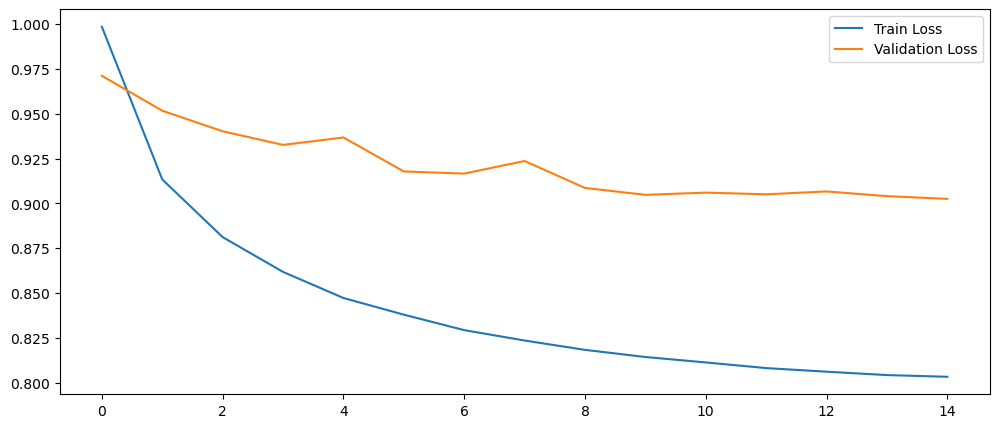

In [91]:
print("------- List Hyper Parameters -------")
print("epochs ->", epochs)
print("batch size ->", batch_size)
print("Optimizer ->", optimizer)

train_losses, val_losses = batch_gd(model, criterion, optimizer, epochs)

plt.figure(figsize=(12,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


In [100]:
# torch.save(model, "model")

In [110]:
model = torch.load('model', weights_only=False)

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)

Test acc: 0.7511


              precision    recall  f1-score   support

           0     0.7020    0.6865    0.6941     38447
           1     0.8138    0.8259    0.8198     65996
           2     0.6839    0.6814    0.6826     35100

    accuracy                         0.7511    139543
   macro avg     0.7332    0.7312    0.7322    139543
weighted avg     0.7503    0.7511    0.7507    139543



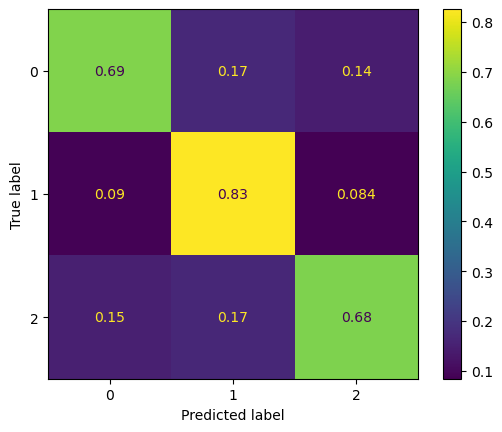

In [111]:
print(classification_report(all_targets, all_predictions, digits=4))
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()